In [1]:
import optuna
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import synergy_dataset as sd
from IPython.display import display
import seaborn as sns

# Path to your SQLite3 database
db_path = ""

# Get all study summaries
study_summaries = optuna.get_all_study_summaries(storage=db_path)

for summary in study_summaries:
    print(f"- {summary.study_name}")

/Users/Kuil0004/Documents/venvs/asreview-2.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- ASReview2-rf_c-52-1
- ASReview2-log-52-1
- ASReview2-nb-52-1
- ASReview2-nb-52-2
- ASReview2-log-52-2
- ASReview2-log-52-3
- ASReview2-log-52-4
- ASReview2-log-52-5
- ASReview2-nb-52-3
- ASReview2-nb-52-4
- ASReview2-demo-svm-1
- ASReview2-demo-log-1
- ASReview2-demo-nb-1
- ASReview2-demo-rf-1
- ASReview2-full-nb-1
- ASReview2-demo-log-2
- ASReview2-demo-log-3
- ASReview2-demo-svm-2
- ASReview2-full-log-1
- ASReview2-demo-rf-2
- ASReview2-full-svm-1
- ASReview2-full-rf-1
- ASReview2-demo-labse-svm-1
- ASReview2-demo-bge-m3-svm-1
- ASReview2-demo-bge-m3-rf-1
- ASReview2-demo-labse-rf-1
- ASReview2-full-tfidf-nb-2
- ASReview2-full-tfidf-nb-3
- ASReview2-full-tfidf-svm-2


In [30]:
study_name = "ASReview2-full-tfidf-nb-2"
direction = "minimize"  # minimize
metric_name = ["Loss", "Losses"]#["NDCG", "NDCGs"]  # ["Loss", "Losses"]
study = optuna.load_study(study_name=study_name, storage=db_path)
print(study.trials[0].params)

dataset_names = []
for i in sd.iter_datasets():
    if i.name != "Chou_2004":
        dataset_names.append(i.name)

dataset_names.sort()

{'ratio': 2.7491599447101134}


In [31]:
# Prepare data for visualization
data = []

for trial in study.trials:
    if trial.intermediate_values:
        values = list(trial.intermediate_values.values())
        for dataset_id, value in enumerate(values):
            if dataset_id >= len(dataset_names):
                continue
            if len(values) > len(dataset_names):
                params = trial.params  # Extract trial parameters
                # Record dataset_id, loss (intermediate value), and parameters
                data.append(
                    {
                        "dataset_id": dataset_id,
                        "metric": value,
                        "sd": values[dataset_id + len(dataset_names)],
                    }
                )

            else:
                params = trial.params  # Extract trial parameters
                # Record dataset_id, loss (intermediate value), and parameters
                data.append(
                    {
                        "dataset_id": dataset_id,
                        "metric": value,
                    }
                )

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Initialize variables to store the best and worst trial per dataset
num_datasets = int(
    len(dataset_names)
)  # Assuming all trials have the same number of datasets
best_trials_per_dataset = [None] * num_datasets  # Store best trial numbers
worst_trials_per_dataset = [None] * num_datasets
best_metric_per_dataset = [float("inf" if direction == "minimize" else "-inf")] * num_datasets  # Store best loss values
worst_metric_per_dataset = [float("-inf" if direction == "minimize" else "inf")] * num_datasets  # Store worst metric values
best_params_per_dataset = [None] * num_datasets  # Store best trial parameters
worst_params_per_dataset = [None] * num_datasets  # Store worst trial parameters
sd_best_trial = [None] * num_datasets
sd_worst_trial = [None] * num_datasets  # Store worst trial standard deviations (optional)

# Loop through all trials to find the best and worst trial for each dataset
for trial in study.trials:
    if trial.intermediate_values:
        # Iterate through each dataset (position in the intermediate_values list)
        values = list(trial.intermediate_values.values())
        for dataset_id, metric in enumerate(values):
            if dataset_id >= len(dataset_names):
                continue
            if direction == "minimize":
                if metric < best_metric_per_dataset[dataset_id]:
                    # Update the best trial info for this dataset
                    best_metric_per_dataset[dataset_id] = metric
                    best_trials_per_dataset[dataset_id] = trial.number
                    best_params_per_dataset[dataset_id] = trial.params
                    if len(values) > len(dataset_names):
                        sd_best_trial[dataset_id] = values[
                            dataset_id + len(dataset_names)
                        ]
                if metric > worst_metric_per_dataset[dataset_id]:
                    # Update the worst trial info for this dataset
                    worst_metric_per_dataset[dataset_id] = metric
                    worst_trials_per_dataset[dataset_id] = trial.number
                    worst_params_per_dataset[dataset_id] = trial.params
                    if len(values) > len(dataset_names):
                        sd_worst_trial[dataset_id] = values[
                            dataset_id + len(dataset_names)
                        ]
            elif direction == "maximize":
                if metric > best_metric_per_dataset[dataset_id]:
                    # Update the best trial info for this dataset
                    best_metric_per_dataset[dataset_id] = metric
                    best_trials_per_dataset[dataset_id] = trial.number
                    best_params_per_dataset[dataset_id] = trial.params
                    if len(values) > len(dataset_names):
                        sd_best_trial[dataset_id] = values[
                            dataset_id + len(dataset_names)
                        ]
                if metric < worst_metric_per_dataset[dataset_id]:
                    # Update the worst trial info for this dataset
                    worst_metric_per_dataset[dataset_id] = metric
                    worst_trials_per_dataset[dataset_id] = trial.number
                    worst_params_per_dataset[dataset_id] = trial.params
                    if len(values) > len(dataset_names):
                        sd_worst_trial[dataset_id] = values[
                            dataset_id + len(dataset_names)
                        ]



In [32]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(
    list(study.best_trial.intermediate_values.items())[:num_datasets],
    columns=["Dataset", f"Mean {metric_name[0]} Mean Best Trial"],
)

# Rename the rows to indicate the dataset number
df.index = dataset_names
df.drop("Dataset", inplace=True, axis=1)

# Create a DataFrame for the best_metric_per_dataset (make sure it has the same index as df)
df_best = pd.DataFrame(best_metric_per_dataset, columns=[f"Mean {metric_name[0]} Best Overall"])
df_best.index = dataset_names

# Create a DataFrame for the best_metric_per_dataset (make sure it has the same index as df)
df_worst = pd.DataFrame(worst_metric_per_dataset, columns=[f"Mean {metric_name[0]} Worst Overall"])
df_worst.index = dataset_names

# Combine both DataFrames by aligning the index
df_combined = pd.concat([df, df_best, df_worst], axis=1)

display(df_combined)

,Mean Loss Mean Best Trial,Mean Loss Best Overall,Mean Loss Worst Overall
Appenzeller-Herzog_2019,0.047171,0.047169,0.059584
Bos_2018,0.014234,0.008548,0.019257
Brouwer_2019,0.008065,0.007690,0.015667
Chou_2003,0.084324,0.080036,0.091948
Donners_2021,0.086914,0.081939,0.122689
Hall_2012,0.009313,0.008087,0.010460
Jeyaraman_2020,0.095754,0.093063,0.135157
Leenaars_2019,0.003526,0.003298,0.003838
Leenaars_2020,0.080386,0.077329,0.163722
Meijboom_2021,0.080029,0.078570,0.109445


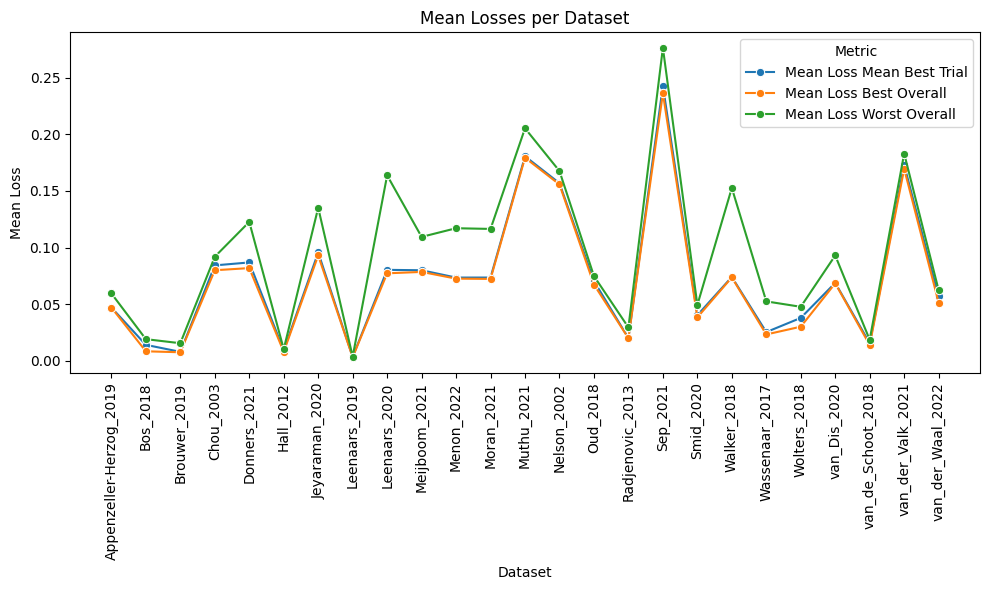

In [33]:
# Convert the combined DataFrame to long-form for seaborn
df_long = df_combined.reset_index().melt(id_vars="index", value_vars=df_combined.columns)
df_long.columns = ['Dataset', 'Metric', 'Value']

# Plot with seaborn lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='Dataset', y='Value', hue='Metric', marker='o')

# Customize the plot
plt.title(f"Mean {metric_name[1]} per Dataset")
plt.xlabel("Dataset")
plt.ylabel(f"Mean {metric_name[0]}")
plt.xticks(rotation=90)  # Rotate dataset labels if needed
plt.tight_layout()
plt.show()

In [34]:
# Create a pandas DataFrame
df = pd.DataFrame(best_params_per_dataset)

# Rename the rows to indicate the dataset number
df.index = dataset_names

display(df)

,ratio
Appenzeller-Herzog_2019,1.200502
Bos_2018,9.980441
Brouwer_2019,1.501868
Chou_2003,1.697119
Donners_2021,1.045977
Hall_2012,2.466523
Jeyaraman_2020,1.036465
Leenaars_2019,1.418466
Leenaars_2020,1.019123
Meijboom_2021,1.266576


TypeError: 'Axes' object is not subscriptable

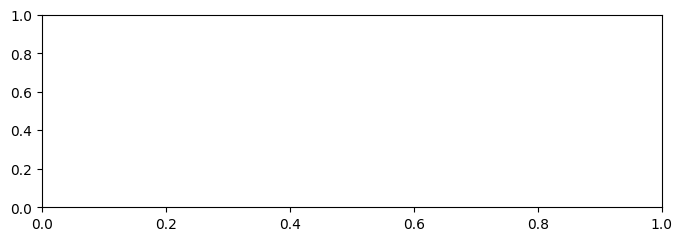

In [35]:
# Plot each parameter separately
num_params = len(df.columns)
fig, axes = plt.subplots(num_params, 1, figsize=(8, num_params * 2.5), sharex=False)

for idx, param in enumerate(df.columns):
    ax = axes[idx]
    ax.plot(
        dataset_names,
        df[param],
        marker="o",
        linestyle="-",
        color="b",
        alpha=0.8,
        label=param,
    )
    ax.set_title(param, fontsize=10)
    ax.set_ylabel("Value", fontsize=8)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.tick_params(axis="y", labelsize=8)
    ax.legend(fontsize=8, loc="upper left")

    # Set dataset names as x-tick labels for each plot
    ax.set_xticks(dataset_names)  # Setting positions explicitly
    ax.set_xticklabels(dataset_names, fontsize=8, rotation=90)  # Setting labels

# Add x-axis label only to the bottom subplot
axes[-1].set_xlabel("Datasets", fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Save or show the plot
# plt.savefig("parameter_comparison_lineplots_all_xticks_fixed.pdf", bbox_inches="tight", dpi=300)
plt.show()

/var/folders/ls/wcyl7trn42jcdp0b2tp0mqqr0000gn/T/ipykernel_4472/1705286192.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=dataset_names, showmeans=True, patch_artist=True)


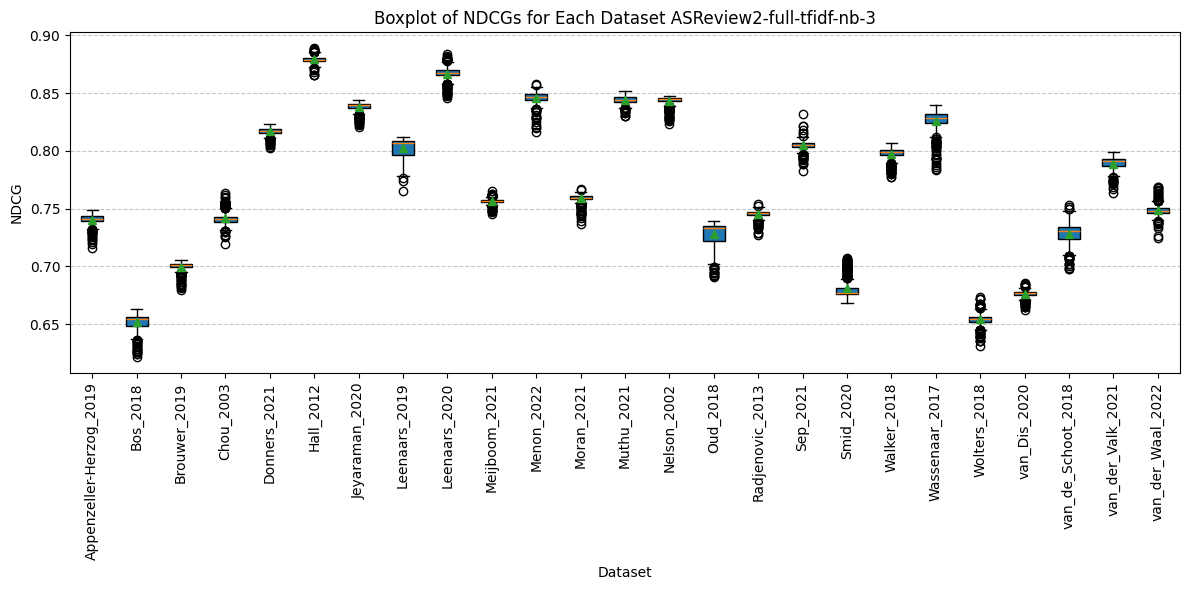

In [18]:
# Extract intermediate values grouped by dataset_id
dataset_intermediate_values = defaultdict(list)

for trial in study.trials:
    if trial.intermediate_values:
        # Distribute intermediate values by dataset_id (index in the list)
        for dataset_id, value in enumerate(trial.intermediate_values.values()):
            if dataset_id >= 25:
                continue
            dataset_intermediate_values[dataset_id].append(value)

# Prepare data for boxplots
datasets = list(dataset_intermediate_values.keys())
boxplot_data = [dataset_intermediate_values[dataset_id] for dataset_id in datasets]

# Plot boxplots
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=dataset_names, showmeans=True, patch_artist=True)
plt.xlabel("Dataset")
plt.ylabel(metric_name[0])
plt.title(f"Boxplot of {metric_name[1]} for Each Dataset {study_name}")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=90)  # Rotate dataset names for better readability
plt.tight_layout()

# Show the plot
plt.tight_layout()
# plt.savefig(f"boxplot_per_dataset_{study_name}.pdf")
plt.show()


# Full Comparison

In [ ]:
dfs = []
trial_ids = {}
for model in ["svm", "rf", "log", "nb"]:
    study = optuna.load_study(study_name=f"ASReview2-full-{model}-1", storage=db_path)
    df = pd.DataFrame(
        list(study.best_trial.intermediate_values.items()),
        columns=["Dataset", "Mean Loss"],
    )
    df["Dataset"] = [dataset_names[i] for i in df["Dataset"]]
    df["Model"] = model
    dfs.append(df)
    trial_ids[model] = study.best_trial.number

# Combine all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x="Dataset", y="Mean Loss", hue="Model", marker="o")
plt.title("Mean Losses per Dataset per model")
plt.xlabel("Dataset")
plt.xticks(rotation=90)
plt.ylabel("Mean Loss")
plt.tight_layout()
plt.show()

In [ ]:
# Filter out data for NB and SVM models
nb_df = combined_df[combined_df["Model"] == "nb"].set_index("Dataset")
svm_df = combined_df[combined_df["Model"] == "svm"].set_index("Dataset")

# Calculate the difference: NB - SVM
diff_df = nb_df["Mean Loss"] - svm_df["Mean Loss"]
diff_df = diff_df.reset_index()
diff_df.columns = ["Dataset", "Difference (NB - SVM)"]

# Plot the differences
plt.figure(figsize=(10, 6))
sns.lineplot(data=diff_df, x="Dataset", y="Difference (NB - SVM)", palette="coolwarm")
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title("Difference in Mean Loss (NB - SVM)")
plt.xlabel("Dataset")
plt.xticks(rotation=90)
plt.ylabel("Difference (NB - SVM)")
plt.tight_layout()
plt.show()